<a href="https://colab.research.google.com/github/ellagattis/hpc/blob/main/assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2
Ella Buehner Gattis 

student number 017015416

In [ ]:
import numpy as np
import numba
import math
import time
from numba import cuda

In [ ]:
#copied from notes for comparison/evaluation
from scipy.sparse import coo_matrix

def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f

# Part 1: improving the 5-point stencil in CUDA

1) In our implementation we generated an operator $A:\mathbb{R}^{N^2}\rightarrow \mathbb{R}^{N^2}$ that for the vector product $Ax$ returned the entries $x_k$ if $k$ was associated with a boundary coordinate, and the 5-point stencil around $x_k$ otherwise. We want to modify this a little bit now. Remember that the operator $A$ discretised the PDE 
$$-\Delta u = f$$
for $u\in [0, 1]^2$  with $u=g$ on the boundary for a given boundary function $u$. We now want to set the boundary values explicitly to zero, that is for each boundary point $x_k$ we always have $x_k = 0$. We can therefore reduce the system to something that only acts on the interior grid points, giving us an operator $\tilde{A}:\rightarrow \mathbb{R}^{(N-2)^2}\rightarrow\mathbb{R}^{(N-2)^2}$ where the vector $\tilde{x}$ when we apply $\tilde{A}\tilde{x}$ only contains the interior points $u_{i,j}$ for $0 < i,j < N$.

$-\Delta u_{i, j}\approx \frac{4u_{i, j} - u_{i - 1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j+ 1}}{h^2}$

2) We noticed in Assignment 2 that our implementation was inefficient. We had as many accesses to global memory as we had operations in each thread. We want to fix this by using a thread block to read a block of grid points into shared memory so that within the thread block we only need to access the shared memory for evaluating the 5-point stencil. Be careful on the boundary of your thread block. You will need to read in a slightly larger neighborhood around the grid points associated with the threads in your threadblock so that all neighboring points are in shared memory (unless you are at the border of the grid).

3) We want to allow a larger class of possible PDE problems, namely so called modified Helmholtz problems of the form
$$-\Delta u + \omega^2 u = f$$
with zero boundary conditions. Hand over an optional `omega` parameter to the kernel so that the kernel evaluates the discretisation of this modified Helmholtz problem. For `omega=0 ` we just have the original Poisson problem. 
Modify the implementation from Assignment 2 by integrating these three changes. Think carefully about the local block sizes and explain your implementation and your choice of thread blocks and memory movements thoroughly. Validate your implementation by comparing to evaluations with the matrix $A$ from the `discretise_poisson` function, where you set the entries of the input vector $x$ associated with boundary values, explicitly to 0. Note that the matrix $A$ from `discretise_poisson` returns a vector $y=Ax$ that contains also the zeros on the boundary. So you need to filter out the boundary values in $y$ for the validation.

Show benchmark results for your new implementation by comparing timing for matrix-vector products from the previous implementation in Assignment 2. For the timings use the %timeit magic command from Jupyter to achieve high accuracy.



In [ ]:
@cuda.jit
def discrete_laplace(vec_in, vec_out, N, omega):
    """Evaluate the discrete Laplace operator."""
    
    #set up shared array size (TPB+2, TPB+2)
    shared_array = cuda.shared.array((34, 34), numba.float64)

    #get thread positions
    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    #get block positions
    bx = cuda.blockIdx.x
    by = cuda.blockIdx.y

    #get grid coordinates
    i, j = cuda.grid(2)
    
    #check we are within bounds
    if i >= N-2:
        return
    if j >= N-2:
        return
    
    # Compute the vector index
    k = j * (N-2) + i

    #shared array element positions
    ax = tx + 1
    ay = ty + 1

    #load matrix elements into the shared memory:
    shared_array[ax, ay] = vec_in[k]

    #deal with top row 

    #load top row of array
    if ty == 0:
      shared_array[ax, ay-1] = vec_in[k-N+2]
    #top row of blocks in grid
    #if by == 0: #
    if j == 0:
      shared_array[ax, ay-1] = numba.float64(0)
        
    #deal with bottom row
      
    #load bottom row of array
    if ty == (TPB - 1):
      shared_array[ax, ay+1] = vec_in[k+N-2]
    #bottom row of blocks in grid
    #if by == (nblocks-1): #
    if j == (N-2-1):
      shared_array[ax, ay+1] = numba.float64(0)
        
    #deal with left edge

    #load left column of array
    if tx == 0:
      shared_array[ax-1, ay] = vec_in[k-1]
    #leftmost column of blocks in grid
    #if bx == 0: #
    if i == 0:
      shared_array[ax-1, ay] = numba.float64(0)
        
    #deal with right edge
      
    #load right column of array
    if tx == (TPB - 1):
      shared_array[ax+1, ay] = vec_in[k+1]
    #rightmost column of blocks in grid
    #if bx == (nblocks-1): #
    if i == (N-2-1):
      shared_array[ax+1, ay] = numba.float64(0)
        
    # sync all threads
    cuda.syncthreads()
    
    # work out the interior elements of our array
    up = shared_array[ax, ay - 1]
    down = shared_array[ax, ay + 1]
    left = shared_array[ax - 1, ay]
    right = shared_array[ax + 1, ay]
    center = shared_array[ax,ay]
    
    vec_out[k] = (N - 1)**2 * ((numba.float64(4) * center) - up - down - left - right) + (omega**2*center)

This kernel evaluates the discrete Laplacian using CUDA to parallelize the evaluation. It parallelizes the calculation using threadblocks of size 32x32, and as many blocks as are necessary for a particular N value. It creates a shared array of dimension TPB+2, TPB+2 to load the matrix elements-  this is because to evaluate the five point stencil we need the four surrounding points, so for points on the edge of the threadblock, we will need to load the points just outside of it into the shared array too. Loading the interior points is straightforward, since they will just correspond to the vector index. We use if statements to find wether the point is on the edge of the array, and if it is on the outside of the grid, ie is a boundary value, in which case the value is set to zero, or just the edge of an (interior) threadblock, in which case we load the corresponding vector element. Then, we just evaluate the five point stencil as before, using the corresponding points in the shared array, and with the added $\omega^2$ term for the modified Helmholtz problems. The solutions are written to vec_out as a 1d array.

Below I have adapted the eval_gpu function from last week's assignment to incorporate my function. It creates device arrays for the result to be written into and for x, and calculates how many threadblocks are needed. I have declared N and omega as global variables so that later when I create the linear operator wrapper it does not have dependencies on N or omega.

In [ ]:
def eval_gpu(x):
    """Evaluate the discrete Laplacian on the GPU."""

    #make N and omega global so they are not required as inputs
    global N, omega
    
    nblocks = (N + 31) // 32

    #write arrays to device
    result_arr = np.zeros((N-2)**2, dtype = np.float64)
    result_global_mem = cuda.to_device(result_arr)
    x_global_mem = cuda.to_device(x.astype('float64'))

    discrete_laplace[(nblocks, nblocks), (32, 32)](x_global_mem, result_global_mem, N, omega)
    res = result_global_mem.copy_to_host()
    return res.astype('float64')

In [ ]:
rand = np.random.RandomState(0)

N = 50

TPB = 32 #threads per block
omega = 0 #set omega=0 for original laplace problem to compare with CPU implementation
nblocks = (N-2 + 31) // 32

A, _ = discretise_poisson(N)

#make x matrix and set all boundary values to 0
x = rand.randn(N,N)
x[:,[0,-1]] = x[[0,-1]] = 0
x = np.reshape(x, N*N)

#slice x so it only contains the interior values
x_2d = np.reshape(x, (N, N))
x_reduced = x_2d[1:(N-1),1:(N-1)]
x_red = np.reshape(x_reduced, (N-2)**2)

y_gpu = eval_gpu(x_red)
y_cpu = A @ x

#retrieve just interior values of CPU result
y_cpu_2d = np.reshape(y_cpu, (N, N))
y_cpu_reduced = y_cpu_2d[1:(N-1),1:(N-1)]
y_cpu = np.reshape(y_cpu_reduced, (N-2)**2)

#validate against CPU implementation.
rel_error = np.linalg.norm(y_cpu - y_gpu, np.inf)/np.linalg.norm(y_cpu, np.inf)
print(f"Relative error: {rel_error}.")

Relative error: 3.345890213357407e-16.


The relative error given by this code is very small, indicating that my code is correct. The tiny discrepancy could be due to differences in single/double precision.

In [ ]:
#copied from solutions for assignment 2 for benchmark comparison
@cuda.jit
def evaluate_discrete_laplace(vec_in, vec_out, N):
    """Evaluate the discrete Laplace operator."""
    
    i, j = cuda.grid(2)
    
    if i >= N:
        return
    if j >= N:
        return
    
    # Compute the vector index
    k = j * N + i
    
    if i == 0 or i == N - 1 or j == 0 or j == N - 1:
        # We are at the boundary
        # Here, the matrix just acts like the identity
        vec_out[k] = vec_in[k]
        return
    
    # Now deal with the interior element
    
    up = vec_in[(j + 1) * N + i]
    down = vec_in[(j - 1) * N + i]
    left = vec_in[j * N + i - 1]
    right = vec_in[j * N + i + 1]
    center = vec_in[k]
    
    vec_out[k] = (N - 1)**2 * (numba.float64(4) * center - up - down - left - right)
    
def eval_gpu_2(x, N):
    """Evaluate the discrete Laplacian on the GPU."""
    
    res = np.empty(N * N, dtype=np.float64)
    
    nblocks = (N + 31) // 32
    evaluate_discrete_laplace[(nblocks, nblocks), (32, 32)](x.astype('float64'), res, N)
    return res.astype('float64')

In [ ]:
#call once to allow compile time to not interfere with benchmarking
eval_gpu_2(x, N)

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
#copied & modified from solutions for assignment 2
def benchmark(N):
    """Benchmark the CPU and GPU implementation."""

    omega = 1
    
    x = rand.randn(N,N)
    x[:,[0,-1]] = x[[0,-1]] = 0
    x = np.reshape(x, N*N)

    #slice x so it only contains the interior values
    x_2d = np.reshape(x, (N, N))
    x_reduced = x_2d[1:(N-1),1:(N-1)]
    x_red = np.reshape(x_reduced, (N-2)**2)

    print("Assignment 2 Benchmark")
    %timeit y_gpu_ass2 = eval_gpu_2(x, N)
    
    print("Assignment 3 Benchmark")
    %timeit y_gpu = eval_gpu(x_red)

print("Small size benchmark (n=100)")
print("----------------------------")
benchmark(N=100)
print("\nLarge size benchmark (n=1000)")
print("-------------------------------")
benchmark(N=1000)

Small size benchmark (n=100)
----------------------------
Assignment 2 Benchmark
CPU times: user 1.8 ms, sys: 758 µs, total: 2.56 ms
Wall time: 2.62 ms
Assignment 3 Benchmark
CPU times: user 2.46 ms, sys: 59 µs, total: 2.52 ms
Wall time: 2.41 ms

Large size benchmark (n=1000)
-------------------------------
Assignment 2 Benchmark
CPU times: user 9.35 ms, sys: 7.86 ms, total: 17.2 ms
Wall time: 16.8 ms
Assignment 3 Benchmark
CPU times: user 5.04 ms, sys: 1.01 ms, total: 6.05 ms
Wall time: 5.89 ms


The exact timings change with every run, but as I write this the benchmark results for N=100 were 2.56 ms per loop for the version from assignment 2 and 2.52 ms per loop for my function. For N=1000, the benchmark results were 17.2 ms per loop for the version from assignment 2 and 6.05 ms per loop for my function. This shows that reducing global memory accesses offers significant speedup for high N values, but at low N the two speeds are comparable, and this version may even be slower due to the time associated with writing to the device. However clearly at higher N values using a shared memory array to reduce global memory accesses is worth it.

I changed the benchmarking code to use %time instead of %timeit because it wasn't working for me in Google Colab (was giving inaccurate times). The times I recorded here were found using %time rather than %timeit, but I have now changed the code back to use %timeit since this is what we were told to use.

# Part 2 - Solving modifed Helmholtz problems with CG on the GPU

(Hint: If you fail to write a GPU implementation in Part 1, you can also write a CPU implementation so that you can still do Part 2. However, you won’t receive any Part 1 marks for it.)

Your CUDA function from the first part takes a vector and returns a vector. It is an implementation of a linear operator. In Part 2 we want to hook this up with the CG solver from Scipy so that we can solve actual PDE problems on the GPU. In order to do this Scipy provides the `class scipy.sparse.linalg.LinearOperator`. This class is a wrapper for routines that evaluate matrix-vector products and turns them into objects that can be passed to iterative solvers. Wrap your solution from Part 1 into a LinearOperator so that you can interface it with the built-in Scipy iterative solvers. Once you have done this use the CG function from Scipy to solve the linear system of equations
$$\tilde{A}x = f,$$
where $\tilde{A}$ is represented through your linear operator. For $f$ simply choose the function with all ones. Make plots of the convergence of the relative residual $\|Ax_k-b\|_2/\|b\|_2$. As solver tolerance you can choose the default value. Plot within the same graph the convergence curves for different values of $\omega > 0 $. Try to explain your observations from what you know about the convergence bounds for CG.

Finally, visualize your PDE solution for $\omega = 1$ using `imshow`.

In [ ]:
from matplotlib import pyplot as plt
from scipy.sparse.linalg import cg, LinearOperator

In [ ]:
N= 500

#create linear operator
A_tilde = LinearOperator(((N-2)**2,(N-2)**2), matvec=eval_gpu)

f = np.ones((N-2)**2)

residuals = []

Here I have constructed a linear operator from my eval_gpu function, and created a vector f. This wrapper allows my function to be passed to an iterative solver, namely the conjugate gradient solver from scipy, which I use below. The LinearOperator wrapper requires specification of the matrix size which is here $(N-2)^2\times (N-2)^2$ , and the function passed. It returns a vector of length of the first dimension of the matrix- so in our case $(N-2)^2$. The conjugate gradient method solves problems of the form Ax = f.

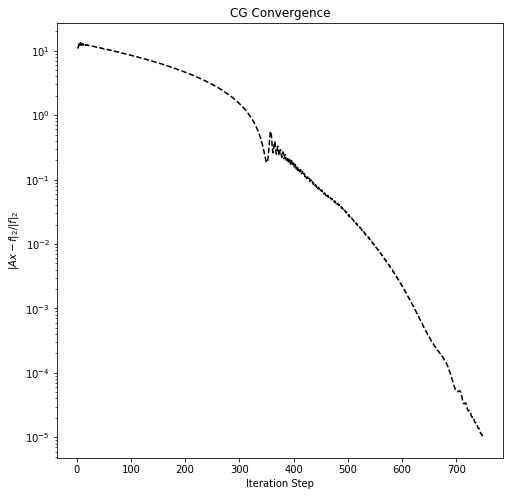

In [ ]:
callback = lambda x: residuals.append(np.linalg.norm(f - A_tilde.matvec(x)) / np.linalg.norm(f))

sol, _ = cg(A_tilde, f, callback=callback, maxiter=1000)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.semilogy(1 + np.arange(len(residuals)), residuals, 'k--')
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-f\|_2 / \|f\|_2$')

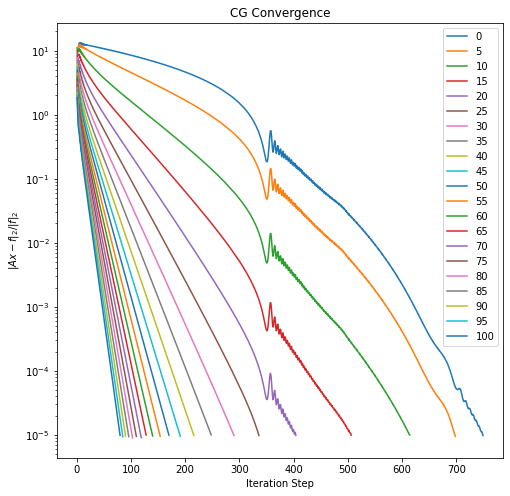

In [ ]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title('CG Convergence')
ax.set_xlabel('Iteration Step')
_ = ax.set_ylabel('$\|Ax-f\|_2 / \|f\|_2$')
for omega in np.arange(0, 101, 5):
  residuals = []
  sol, _ = cg(A_tilde, f, callback=callback, maxiter=1000)
  ax.semilogy(1 + np.arange(len(residuals)), residuals, label = omega)
  ax.legend()

Here I have graphed the convergence curves for values of omega between 0 and 100. In order for the solver to converge successfully all of the values had to be float64's, rather than float32s as I had previously, because otherwise the precision was too low. It appears from the graphs that the spread of the curves follows a logarithmic spread (the x intercepts, ie the step at which it converges). For lower $\omega$ values the curves appear closer and closer together and at higher $\omega$ values more spread apart.

$\kappa := \frac{\lambda_{max}}{\lambda_{min}}$ where $\lambda_{max}$ and $\lambda_{min}$ are the largest and smallest eigenvalue of A.$\kappa$ is the condition number of A and dictates the rate of convergence. Adding in our factor of $\omega^2$ adds a factor to the lead diagonal of A, thus bringing the largest and smallest eigenvalues closer together. Increasing $\omega$ causes the eigenvalues to converge, meaning $\kappa$ will tend towards 1, decreasing the convergence factor which depends on $2\left(\frac{\sqrt{\kappa} - 1}{\sqrt{\kappa} + 1}\right)$ hence increasing the rate of convergence, as we see in the graph. 

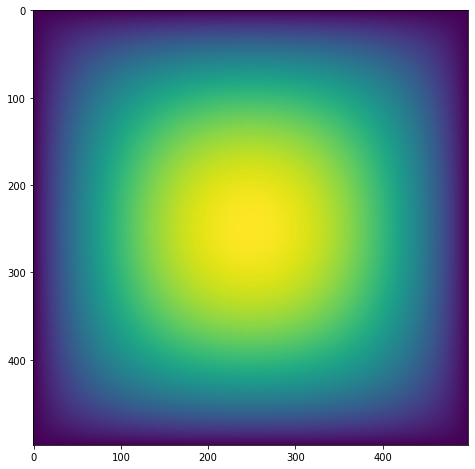

In [ ]:
omega = 1
residuals = []
sol, _ = cg(A_tilde, f, callback=callback, maxiter=1000)
sol = np.reshape(sol, (N-2,N-2))
plt.figure(figsize=(8, 8))
plt.imshow(sol)

Here we visualise the solution generated by the conjugate gradient method using plt.imshow. We see that higher values are centered around the middle with the edges being zeroes.